# Add
* u-g,g-r,r-i,i-z만 사용
* category_features 사용위해 lgb.train사용
* 제출결과 : 0.4161080142

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
import lightgbm as lgb

C:\Users\starl\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# #colab용
# import os
# os.chdir('/content/drive/My Drive/Colab Notebooks/Dacon/천체관측/')

In [4]:
# path = "/content/drive/My Drive/Colab Notebooks/Dacon/천체관측/data/" #colab
path = "./data/" #local
train_df = pd.read_csv(path+'train.csv',index_col=0)
test_df = pd.read_csv(path+'test.csv',index_col=0)
sample_submission_df = pd.read_csv(path+'sample_submission.csv',index_col=0)
pd.options.display.max_columns = 30

In [5]:
train_cols = list(train_df.columns)
test_cols = list(test_df.columns)
train_cols.remove('fiberID')
test_cols.remove('fiberID')

## DATA Setting

In [6]:
column_number = {}
number_columns = {}
for i, column in enumerate(sample_submission_df.columns):
    column_number[column] = i
    number_columns[i] = column
    
    
def to_number(x, dic):
    return dic[x]

train_df['type_num'] = train_df['type'].apply(lambda x: to_number(x, column_number))


In [7]:
def add_minus_feature_all(data,test = False):
    '''
    combination으로 모든 변수들의 조합에 대해서 컬럼생성 
    각 mag에서 가장 높은값의 filter를 받아오는 "~~mag_MAX"생성
    결과 64개로 증가
    '''
    from itertools import combinations
    n = 0
    for count in range(5,21,5):
        s = 2
        if test == True :
            s = 1
        selected = data.columns[s:].values[n:count]
        mag = str.split(selected[0],'_')[0]
        data[mag+"_MAX"] = data[selected].apply(lambda x : str.split(np.argmax(x),'_')[1],axis = 1)
        for combi in list(combinations(selected,2)):
            name_1st = str.split(combi[0],'_')[1]
            name_2nd = str.split(combi[1],'_')[1]
            data[mag+"_"+name_1st+"-"+name_2nd] = data[combi[0]]-data[combi[1]]
        n=count
    return data

In [8]:
def add_minus_feature(data,test = False):
    '''
    근접변수에 대해서만 컬럼생성 ex) 'fiberMag_u-g', 'fiberMag_g-r', 'fiberMag_r-i', 'fiberMag_i-z'
    각 mag에서 가장 높은값의 filter를 받아오는 "~~mag_MAX"생성
    결과 38개로 증가 
    '''
    from itertools import combinations
    n = 0
    m = 0
    for count in range(5,21,5):
        s = 2
        if test == True :
            s = 1
        selected = data.columns[s:].values[n:count]
        mag = str.split(selected[0],'_')[0]
        data[mag+"_MAX"] = data[selected].apply(lambda x : str.split(np.argmax(x),'_')[1],axis = 1)
        for i in range(0,len(selected)):        
            if i>0: 
                name_1st = str.split(m,'_')[1]
                name_2nd = str.split(selected[i],'_')[1]
                data[mag+"_"+name_1st+"-"+name_2nd] = data[m]-data[selected[i]]
            m = selected[i]    
        n=count
    return data

In [9]:
train_df = add_minus_feature(train_df)
test_df = add_minus_feature(test_df,True)

C:\Users\starl\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:61: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return bound(*args, **kwds)


In [10]:
def label_encode(data):
    '''
    각 mag에서 가장 높은값의 filter를 labelencoding 
    '''
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    taget_cols = ['psfMag_MAX','fiberMag_MAX','petroMag_MAX','modelMag_MAX']
    for col in taget_cols:
        data[col] = le.fit_transform(data[col])
    return data

In [11]:
train_df = label_encode(train_df)
test_df = label_encode(test_df)

In [12]:
train_X = train_df.drop(columns=train_cols, axis=1)
train_y = train_df['type_num']
test_X = test_df.drop(columns=test_cols, axis=1)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.3, random_state=42,stratify = train_y)

In [14]:
train_ds = lgb.Dataset(X_train, label = y_train, categorical_feature=['fiberID'])
test_ds = lgb.Dataset(X_test, label = y_test, categorical_feature=['fiberID']) 

In [15]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': train_y.nunique(),
    'metric': {'multi_logloss','multi_logloss'},
    'num_leaves': 25,
    'learning_rate': 0.005,
    'max_depth' : 12,
    'random_state' : 42
}

## Modeling

In [16]:
evaluation_results = {}
lgmb_model = lgb.train(params, train_ds,num_boost_round= 20000, 
                       valid_sets = [train_ds,test_ds], valid_names=['Train', 'Test'],
                       evals_result=evaluation_results,
                       verbose_eval=100, early_stopping_rounds=100)

C:\Users\starl\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds
[100]	Train's multi_logloss: 1.01243	Test's multi_logloss: 1.01441
[200]	Train's multi_logloss: 0.570996	Test's multi_logloss: 0.573022
[300]	Train's multi_logloss: 0.336364	Test's multi_logloss: 0.338241
[400]	Train's multi_logloss: 0.201249	Test's multi_logloss: 0.202932
[500]	Train's multi_logloss: 0.121221	Test's multi_logloss: 0.122716
[600]	Train's multi_logloss: 0.0732555	Test's multi_logloss: 0.0745779
[700]	Train's multi_logloss: 0.044344	Test's multi_logloss: 0.0455095
[800]	Train's multi_logloss: 0.0268693	Test's multi_logloss: 0.0278895
[900]	Train's multi_logloss: 0.0162889	Test's multi_logloss: 0.0171792
[1000]	Train's multi_logloss: 0.00987632	Test's multi_logloss: 0.0106512
[1100]	Train's multi_logloss: 0.00598929	Test's multi_logloss: 0.00665502
[1200]	Train's multi_logloss: 0.00363252	Test's multi_logloss: 0.00420553
[1300]	Train's multi_logloss: 0.00220333	Test's multi_logloss: 0.00269864
[1400]	Train's mu

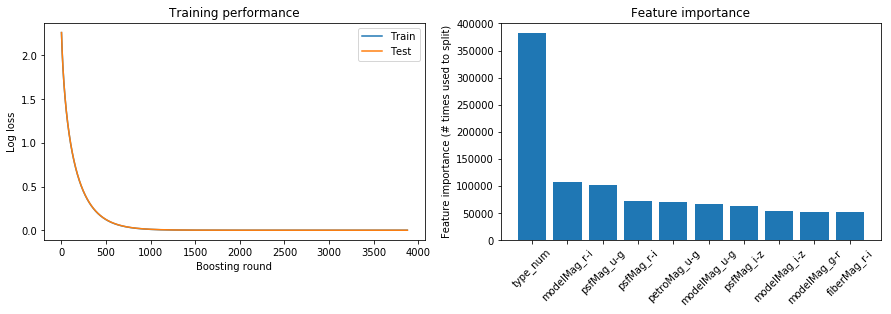

In [17]:
fig, axs = plt.subplots(1, 2, figsize=[15, 4])

# Plot the log loss during training
axs[0].plot(evaluation_results['Train']['multi_logloss'], label='Train')
axs[0].plot(evaluation_results['Test']['multi_logloss'], label='Test')
axs[0].set_ylabel('Log loss')
axs[0].set_xlabel('Boosting round')
axs[0].set_title('Training performance')
axs[0].legend()

# Plot feature importance
importances = pd.DataFrame({'features': lgmb_model.feature_name(), 
                            'importance': lgmb_model.feature_importance()}).sort_values('importance', ascending=False).head(10)
axs[1].bar(x=np.arange(len(importances)), height=importances['importance'])
axs[1].set_xticks(np.arange(len(importances)))
axs[1].set_xticklabels(importances['features'])
axs[1].set_ylabel('Feature importance (# times used to split)')
axs[1].set_title('Feature importance')
plt.xticks(rotation=45)

plt.show()

In [ ]:
train_y_pred = lgmb_model.predict(X_test)

In [ ]:
train_y_pred.shape

In [ ]:
#log_loss
log_loss(y_test,train_y_pred,labels= list(set(y_test)))

In [ ]:
lgmb_model.feature_importance()

### feature_importance

In [ ]:
pi_df = pd.DataFrame(lgmb_model.feature_importance(), index= train_X.columns,columns= ['importance']).sort_values('importance',ascending = False)
pi_df.head(10)

### 예측결과에 대해
* 12번이 모두 6번으로 몰림
중간예측 : 0,2,7,11
망한예측 : 12,17

In [ ]:
cm_result = pd.DataFrame(confusion_matrix(y_test,np.argmax(train_y_pred,axis = 1)))

In [ ]:
cm_result

In [ ]:
plt.figure(figsize =(15,15))
sns.heatmap(cm_result/np.sum(cm_result),annot = True, cmap ='RdYlGn',fmt='.1%')
plt.ylabel("real",fontsize=20)
plt.xlabel("predict",fontsize=20)
plt.show()

# REAL

In [ ]:
train_ds = lgb.Dataset(train_X, label = train_y, categorical_feature=['fiberID'])

In [ ]:
lgmb_model = lgb.train(params, train_ds,num_boost_round= 2000, verbose_eval=100)

In [ ]:
y_pred = lgmb_model.predict(test_X)

In [ ]:
y_pred

In [ ]:
submission = pd.DataFrame(data=y_pred, columns=sample_submission_df.columns, index=sample_submission_df.index)
submission.to_csv('./submisson/submission.csv', index=True)